# Estimates export

```md
From `./results/estimation/{test_name}.npz`
```

In [37]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pickle
import random
import os
import sys
sys.path.append('../../src/')
sys.path.append('../../scripts/')
from solve_kolmogorov import *
from simulate_gillespie import *
from estimate_total_rates import *

from scipy.special import comb as nchoosek
from scipy.optimize import curve_fit

In [38]:
def di_lauro_ak_model(k, N_val, C_a, p_a, alpha_a):
    r"""
    Model fit for pairwise rates a_k, based on:
    Di Lauro et al. "Network inference from population-level observation of epidemics." 
    Scientific Reports 10.1 (2020): 18779.
    """
    k_arr = np.asarray(k, dtype=float)
    rate = np.zeros_like(k_arr)
    inner_idx = (k_arr > 1e-9) & (k_arr < N_val - 1e-9)
    if np.any(inner_idx):
        k_in = k_arr[inner_idx]
        term_k = np.maximum(1e-9, k_in)
        term_N_minus_k = np.maximum(1e-9, N_val - k_in)
        boundary_shape = (term_k**p_a) * (term_N_minus_k**p_a)
        norm_factor = N_val / 2.0
        skew_exponent = alpha_a * (k_in - norm_factor) / (norm_factor if abs(norm_factor) > 1e-9 else 1.0)
        skew_term = np.exp(skew_exponent)
        rate[inner_idx] = np.abs(C_a) * boundary_shape * skew_term
    rate[k_arr <= 1e-9] = 0.0
    rate[k_arr >= N_val - 1e-9] = 0.0
    return rate

In [39]:
def di_lauro_bk_model(k, N_val, C_b, p_b, alpha_b):
    r"""
    Generalized model fit for higher-order rates b_k, based on:
    Di Lauro et al. "Network inference from population-level observation of epidemics." 
    Scientific Reports 10.1 (2020): 18779.
    """
    k_arr = np.asarray(k, dtype=float)
    rate = np.zeros_like(k_arr)
    inner_idx = (k_arr > 1.0 + 1e-9) & (k_arr < N_val - 1e-9)
    if np.any(inner_idx):
        k_in = k_arr[inner_idx]
        term_k = np.maximum(1e-9, k_in)
        term_k_minus_1 = np.maximum(1e-9, k_in - 1)
        term_N_minus_k = np.maximum(1e-9, N_val - k_in)
        boundary_shape = term_k * (term_k_minus_1**p_b) * (term_N_minus_k**p_b)
        norm_factor = N_val / 2.0
        skew_exponent = alpha_b * (k_in - norm_factor) / (norm_factor if abs(norm_factor) > 1e-9 else 1.0)
        skew_term = np.exp(skew_exponent)
        rate[inner_idx] = np.abs(C_b) * boundary_shape * skew_term
    rate[k_arr <= 1.0 + 1e-9] = 0.0
    rate[k_arr >= N_val - 1e-9] = 0.0
    return rate

In [2]:
# setup
N = 1000
I0 = 50
nsims = 100
time_max = 10.0

In [3]:
test_names = ["complete", "random_ER", "regular", "scale_free"]

In [32]:
test_name = test_names[3]
test_name

'scale_free'

In [33]:
estimates = np.load(f'../../results/estimates/{test_name}.npz', allow_pickle=True)

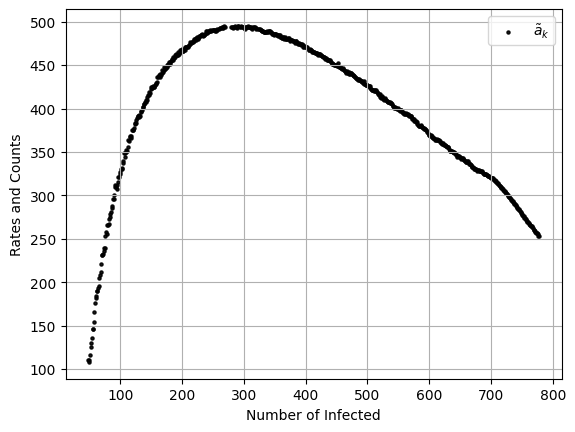

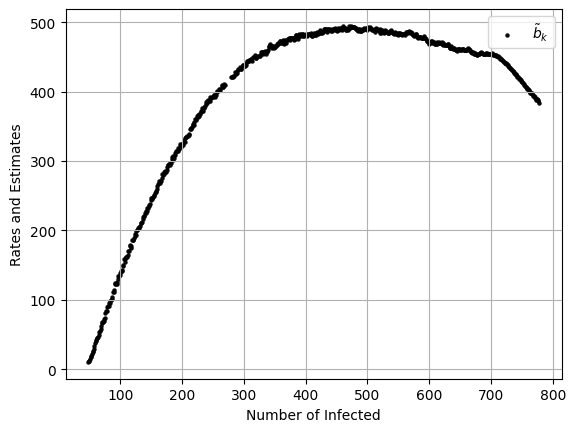

In [34]:
k_values = np.arange(N + 1)
a_k_tilde = estimates["a_k_tilde"]
b_k_tilde = estimates["b_k_tilde"]

# plot only where T_k was non-zero!
min_Tk_threshold = 0.14 # TODO: tune the threshold
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

fig = plt.figure()
ax = plt.subplot()

ax.scatter(k_values[valid_k_idx], a_k_tilde[valid_k_idx], s = 5,
        label=r'$\tilde{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True) 
plt.show()

fig = plt.figure()
ax = plt.subplot()
ax.scatter(k_values[valid_k_idx], b_k_tilde[valid_k_idx], s = 5,
        label=r'$\tilde{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)
plt.show()